目标是预测不同国家/地区的贴纸销售情况。

首先是数据的预处理部分

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np


In [2]:
#读入数据
data_train=pd.read_csv(r'data/train.csv')
data_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
#分析数据形状
data_train.shape

(230130, 6)

In [4]:
data_train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [5]:
#大体查看
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


num_sold有缺失值

In [6]:
data_train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [7]:
#其实占比比较小，可以直接删掉
data_train=data_train.dropna(subset=['num_sold'])
data_train.isna().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [8]:
data_train.shape

(221259, 6)

In [9]:
#将日期拆分开，生成星期，是否为星期天，方便后续处理
#因为贴纸的购物销量可能和工作日和非工作日有关系
data_train['date'] = pd.to_datetime(data_train['date'])
data_train['year'] = data_train['date'].dt.year
data_train['month'] = data_train['date'].dt.month
data_train['day'] = data_train['date'].dt.day
data_train['day_of_week'] = data_train['date'].dt.weekday
data_train['is_weekend'] = data_train['day_of_week'].apply(lambda x: 1 if x > 5 else 0)
data_train.head()

,id,date,country,store,product,num_sold,year,month,day,day_of_week,is_weekend
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,1,4,0


In [10]:
#在把date列删掉，以及没有作用了
data_train = data_train.drop(columns=['date'], axis=1)
data_train.head()

,id,country,store,product,num_sold,year,month,day,day_of_week,is_weekend
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,0
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,0
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,0
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,0
5,5,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,1,4,0


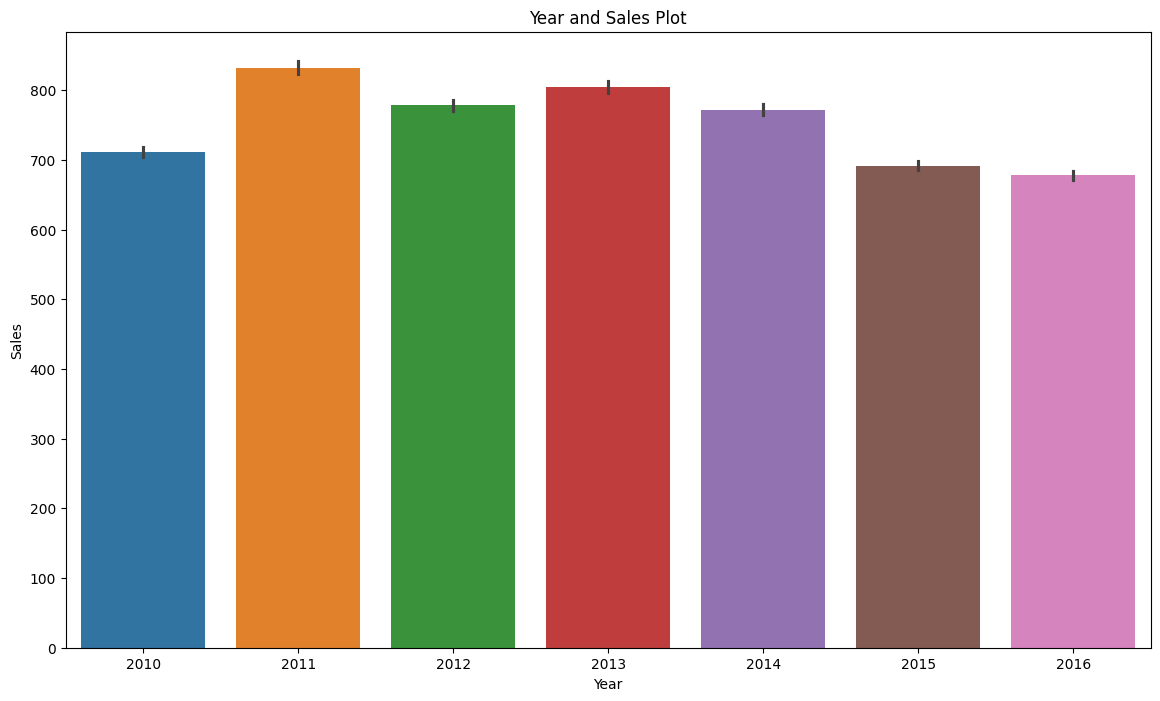

In [11]:
#按照年份看看销售数
fig = plt.figure(figsize=(14, 8))
sns.barplot(data=data_train, x='year', y='num_sold', hue='year',palette='tab10', legend=False)
plt.title('Year and Sales Plot')
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

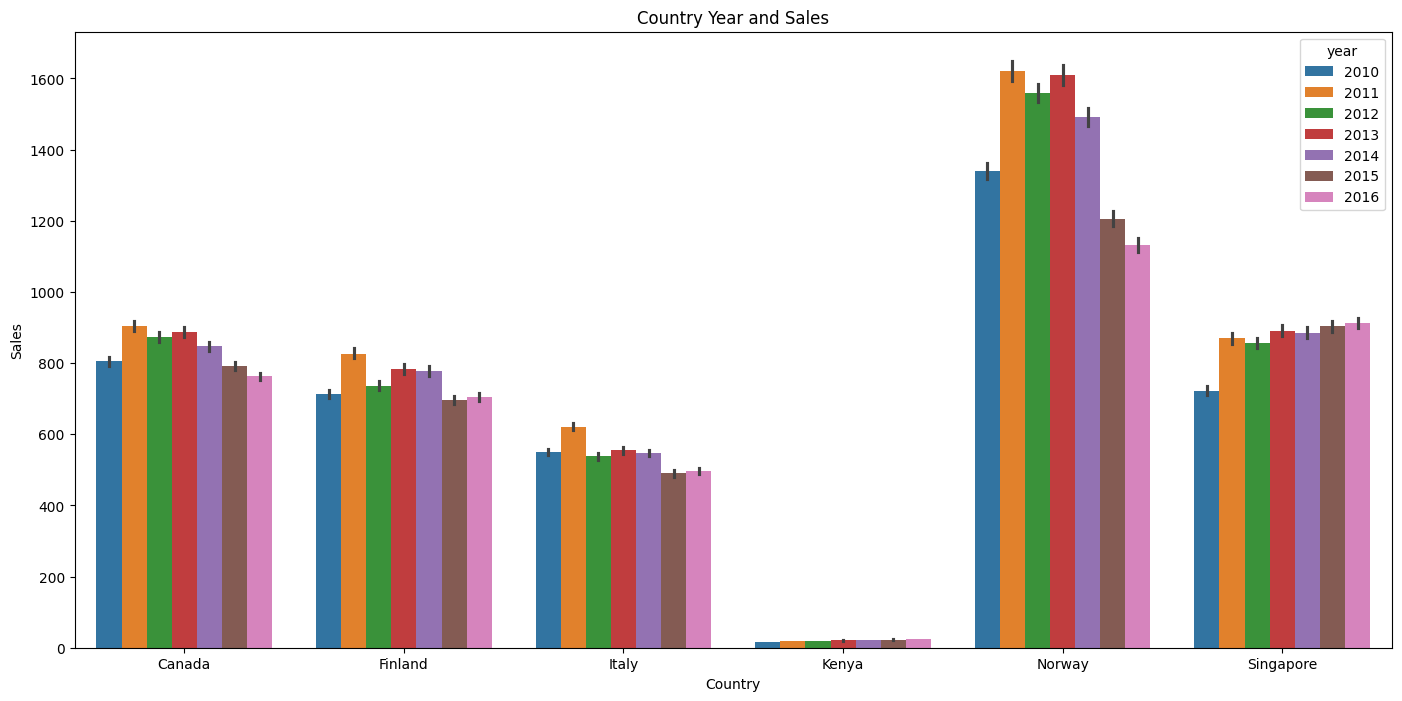

In [12]:
#按照国家和年份来看售卖量
fig=plt.figure(figsize=(17,8))
sns.barplot(data_train,x='country',y='num_sold',hue='year',palette='tab10')
plt.title('Country Year and Sales')
plt.xlabel("Country")
plt.ylabel("Sales")
plt.show()

可以很明显的观察到在kenya的销售数量一直都很少最少，norway每年都是最多的

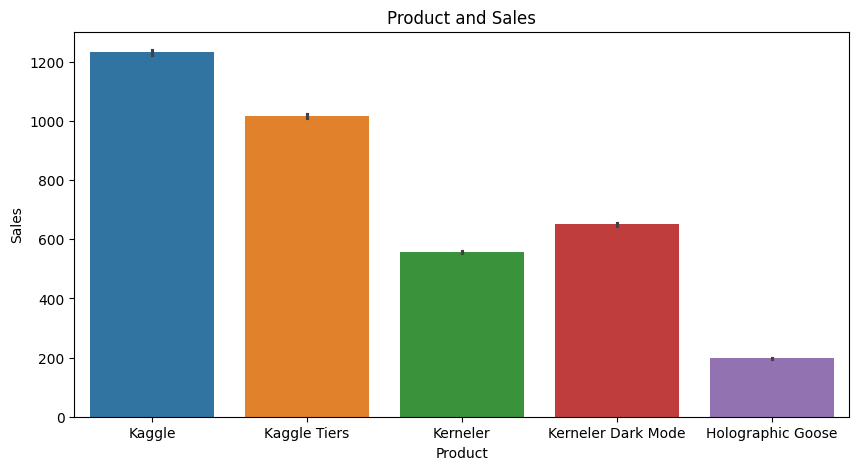

In [13]:
#再查看不同贴纸产品的销售量
fig=plt.figure(figsize=(10,5))
sns.barplot(data_train,x='product',y='num_sold',hue="product",palette='tab10',legend=False)
plt.title("Product and Sales")
plt.xlabel("Product")
plt.ylabel("Sales")
plt.show()

可以看出来Kaggle的销量最好，Holographic Goose最差

In [14]:
#进行独热编码，方便传入模型
data_train=pd.get_dummies(data_train,columns=['country','store','product'],drop_first=True,dtype=int)
data_train.shape

(221259, 18)

In [15]:
data_train.head()

,id,num_sold,year,month,day,day_of_week,is_weekend,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
1,1,973.0,2010,1,1,4,0,0,0,0,0,0,0,0,1,0,0,0
2,2,906.0,2010,1,1,4,0,0,0,0,0,0,0,0,0,1,0,0
3,3,423.0,2010,1,1,4,0,0,0,0,0,0,0,0,0,0,1,0
4,4,491.0,2010,1,1,4,0,0,0,0,0,0,0,0,0,0,0,1
5,5,300.0,2010,1,1,4,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
#将训练集分为特征数据和目标
y=data_train['num_sold']
x=data_train.drop(columns='num_sold',axis=1)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)
#用百分之20的用作测试，剩下的都用于训练模型
#随机种子确保在分割数据集时，每次运行代码都能得到相同的结果，保证一致性和可复现性

模型的训练部分

在下面会使用随机森林进行预测

In [18]:
#随机森林
model_rf=RandomForestRegressor(n_estimators=100,n_jobs=-1) #选用100课树，并加速计算
model_rf.fit(x_train,y_train)
y_pred_rf=model_rf.predict(x_test)

模型评估

In [19]:
rmse_rf=np.sqrt(mean_squared_error(y_test,y_pred_rf))
rmse_rf

67.94027524601246

In [20]:
max(y_test)

5643.0

真实的数据范围是比较大的，所以均方根误差67是不错的，保留

继续进行模型的预测

In [21]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_rf)
print(f"R²: {r2}")

R²: 0.9902124712226307


In [22]:
data_test=pd.read_csv('data/test.csv')
data_test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [23]:
data_test.shape

(98550, 5)

In [24]:
#还是需要进行数据的预处理
data_test=data_test.dropna()
data_test.shape

(98550, 5)

In [25]:
data_test['date'] = pd.to_datetime(data_test['date'])
data_test['year']= data_test['date'].dt.year 
data_test['month']= data_test['date'].dt.month
data_test['day']= data_test['date'].dt.day
data_test['day_of_week'] = data_test['date'].dt.weekday
data_test['is_weekend']= data_test['day_of_week'].apply(lambda x: 1 if x>5 else 0)

In [26]:
data_test= data_test.drop(columns= ['date'], axis= 1)

In [27]:
data_test.head()

,id,country,store,product,year,month,day,day_of_week,is_weekend
0,230130,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1
1,230131,Canada,Discount Stickers,Kaggle,2017,1,1,6,1
2,230132,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1
3,230133,Canada,Discount Stickers,Kerneler,2017,1,1,6,1
4,230134,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1


In [28]:
#同样变成独热编码
data_test= pd.get_dummies(data_test, columns=['country', 'store', 'product'], drop_first= True, dtype= int)

In [29]:
data_result=model_rf.predict(data_test)

In [30]:
submission_file=pd.DataFrame({
    'id': data_test['id'],
    'num_sold': data_result
})
submission_file

,id,num_sold
0,230130,148.14
1,230131,753.47
2,230132,604.53
3,230133,349.37
4,230134,440.00
...,...,...
98545,328675,389.58
98546,328676,2616.77
98547,328677,2023.26
98548,328678,1082.64
